In [5]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import Descriptors, Draw
import matplotlib.pyplot as plt
import seaborn as sns

In [1]:
from tdc.single_pred import ADME
data = ADME(name = 'Caco2_Wang')
split = data.get_split()

Downloading...
100%|██████████| 82.5k/82.5k [00:00<00:00, 285kiB/s] 
Loading...
Done!


In [9]:
print(f"Dataset description: {data.name}")
print(f"Total compounds: {len(data.get_data())}")
df = data.get_data()
print(f"Full dataset shape: {df.shape}")
print(f"Columns: {list(df.columns)}")
df.head()

Dataset description: caco2_wang
Total compounds: 910
Full dataset shape: (910, 3)
Columns: ['Drug_ID', 'Drug', 'Y']


,Drug_ID,Drug,Y
0,(-)-epicatechin,Oc1cc(O)c2c(c1)OC(c1ccc(O)c(O)c1)C(O)C2,-6.220000
1,"(2E,4Z,8Z)-N-isobutyldodeca-2,4,10-triene-8 -y...",C/C=C\C#CCC/C=C\C=C\C(=O)NCC(C)C,-3.860000
2,codeine,COc1ccc2c3c1O[C@H]1[C@@H](O)C=C[C@H]4[C@@H](C2...,-4.090000
3,creatinine,CN1CC(=O)NC1=N,-5.935409
4,danazol,C#C[C@]1(O)CC[C@H]2[C@@H]3CCC4=Cc5oncc5C[C@]4(...,-4.840000


In [8]:
df.isnull().sum()

Drug_ID    0
Drug       0
Y          0
dtype: int64

In [10]:
df.describe()

,Y
count,910.000000
mean,-5.239498
std,0.777236
min,-7.760000
25%,-5.777444
50%,-5.131224
75%,-4.641339
max,-3.510000


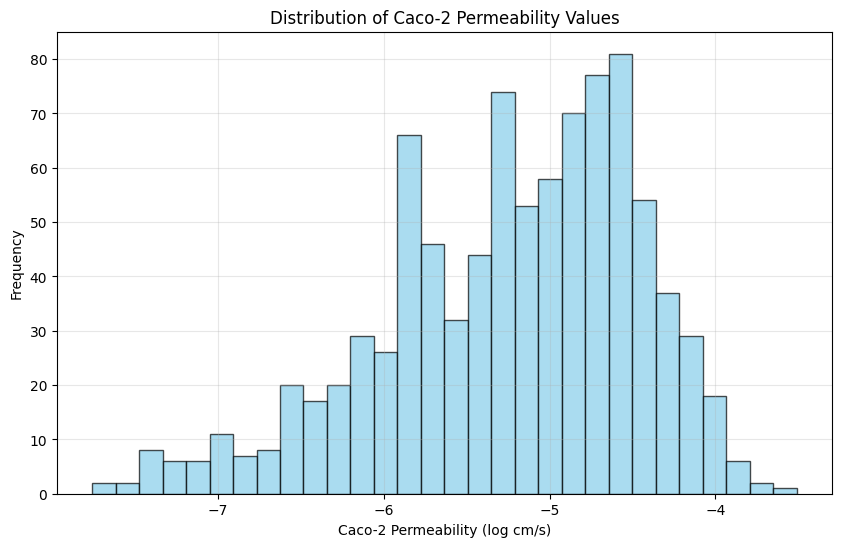

In [12]:
plt.figure(figsize=(10, 6))
plt.hist(df['Y'], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
plt.xlabel('Caco-2 Permeability (log cm/s)')
plt.ylabel('Frequency')
plt.title('Distribution of Caco-2 Permeability Values')
plt.grid(True, alpha=0.3)
plt.show()

In [13]:
print(f"\nDataset splits:")
for split_name, split_data in split.items():
    print(f"{split_name}: {len(split_data)} samples")


Dataset splits:
train: 637 samples
valid: 91 samples
test: 182 samples


In [14]:
smiles_lengths = df['Drug'].apply(len)
print(f"SMILES length statistics:")
print(f"Min length: {smiles_lengths.min()}")
print(f"Max length: {smiles_lengths.max()}")
print(f"Mean length: {smiles_lengths.mean():.2f}")

SMILES length statistics:
Min length: 2
Max length: 221
Mean length: 60.36


In [16]:
df['mol'] = df['Drug'].apply(lambda x: Chem.MolFromSmiles(x) if Chem.MolFromSmiles(x) else None)

invalid_mols = df['mol'].isnull().sum()
print(f"Invalid SMILES: {invalid_mols}")

if invalid_mols > 0:
    df = df.dropna(subset=['mol'])
    print(f"Removed {invalid_mols} invalid molecules")

print("\nCalculating molecular descriptors...")
df['mol_weight'] = df['mol'].apply(Descriptors.MolWt)
df['logP'] = df['mol'].apply(Descriptors.MolLogP)
df['num_atoms'] = df['mol'].apply(lambda x: x.GetNumAtoms())
df['num_bonds'] = df['mol'].apply(lambda x: x.GetNumBonds())
df['num_rotatable_bonds'] = df['mol'].apply(Descriptors.NumRotatableBonds)
df['num_h_donors'] = df['mol'].apply(Descriptors.NumHDonors)
df['num_h_acceptors'] = df['mol'].apply(Descriptors.NumHAcceptors)

descriptor_cols = ['mol_weight', 'logP', 'num_atoms', 'num_bonds',
                   'num_rotatable_bonds', 'num_h_donors', 'num_h_acceptors']

print("\nMolecular descriptor statistics:")
print(df[descriptor_cols].describe())

Invalid SMILES: 0

Calculating molecular descriptors...

Molecular descriptor statistics:
       mol_weight        logP   num_atoms   num_bonds  num_rotatable_bonds  \
count  910.000000  910.000000  910.000000  910.000000           910.000000   
mean   414.679640    2.130127   29.364835   31.538462             5.747253   
std    156.122185    2.156939   11.066400   12.217778             3.992549   
min     32.042000   -7.571400    2.000000    1.000000             0.000000   
25%    307.434000    0.997125   22.000000   23.000000             3.000000   
50%    400.443500    2.465750   28.000000   31.000000             6.000000   
75%    514.698000    3.541850   36.000000   40.000000             8.000000   
max    967.021000    8.687800   68.000000   74.000000            23.000000   

       num_h_donors  num_h_acceptors  
count    910.000000       910.000000  
mean       2.442857         5.808791  
std        2.013849         2.932075  
min        0.000000         1.000000  
25%        1

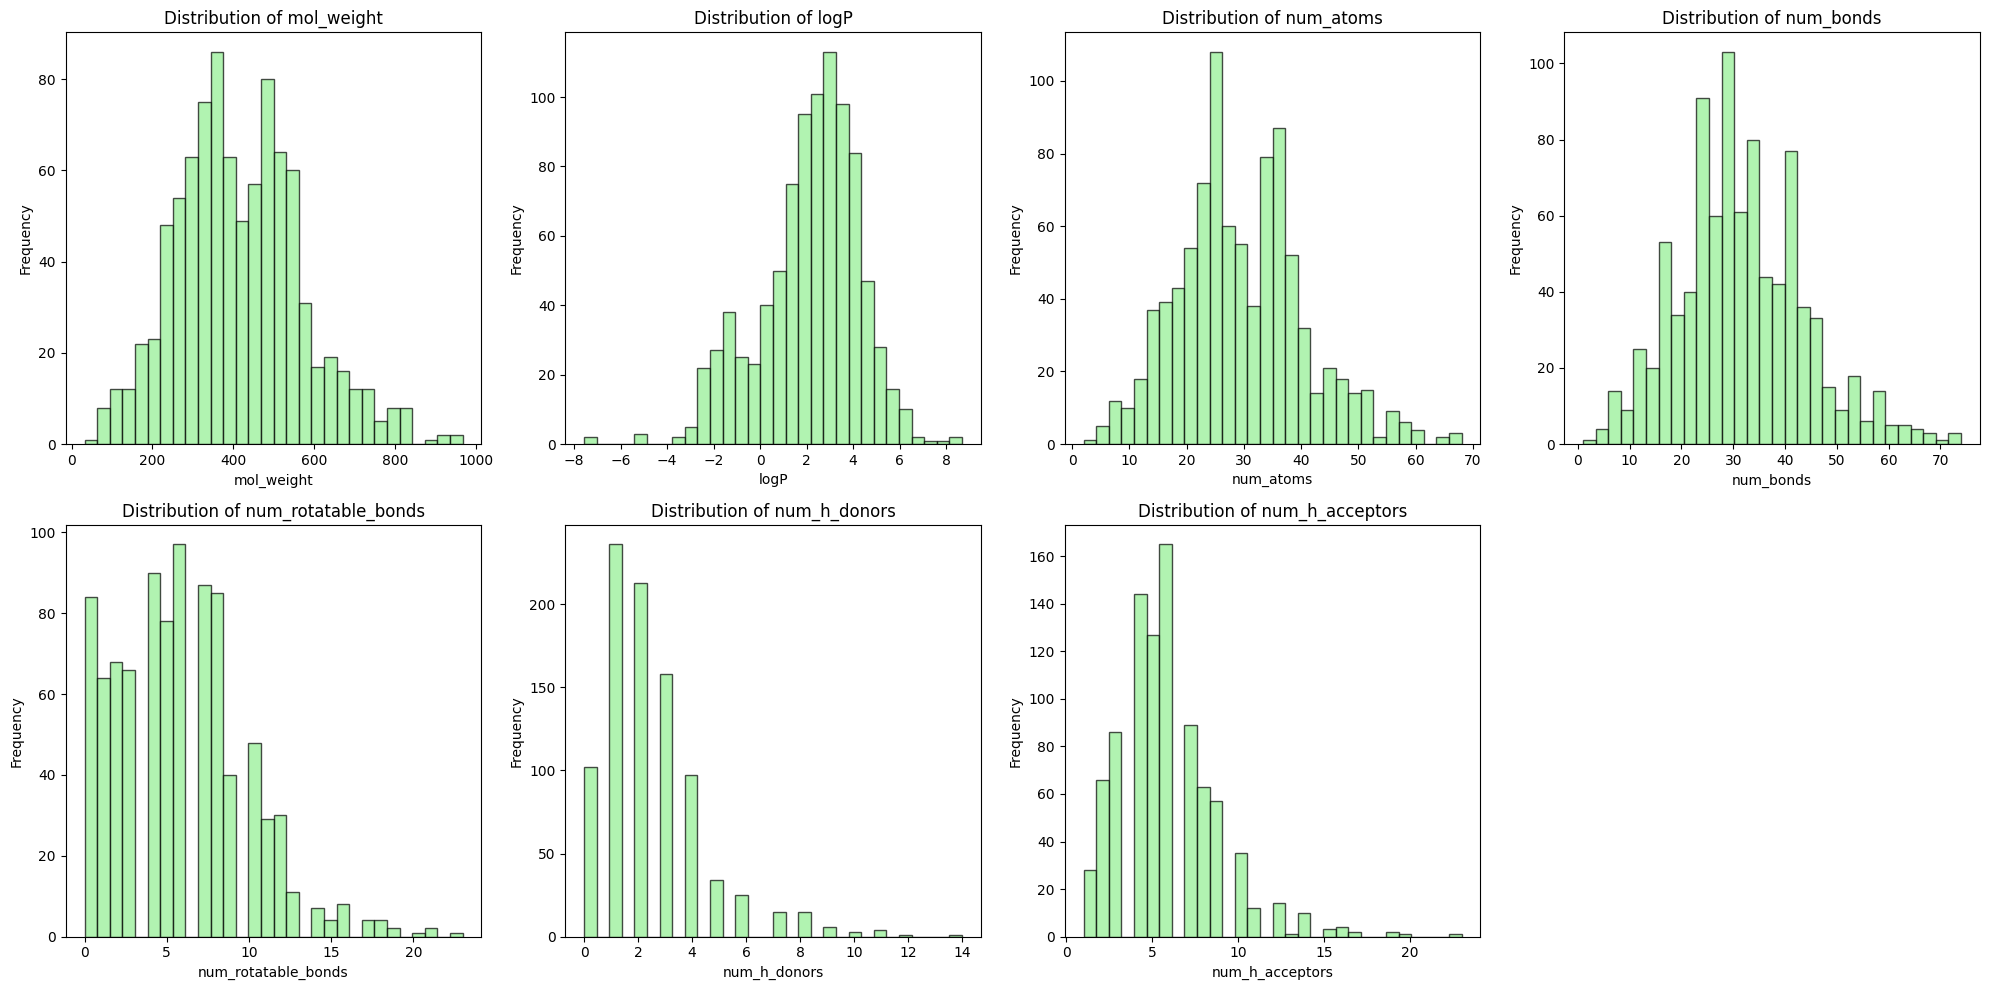

In [17]:
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

for i, col in enumerate(descriptor_cols):
    axes[i].hist(df[col], bins=30, alpha=0.7, color='lightgreen', edgecolor='black')
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')

for i in range(len(descriptor_cols), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

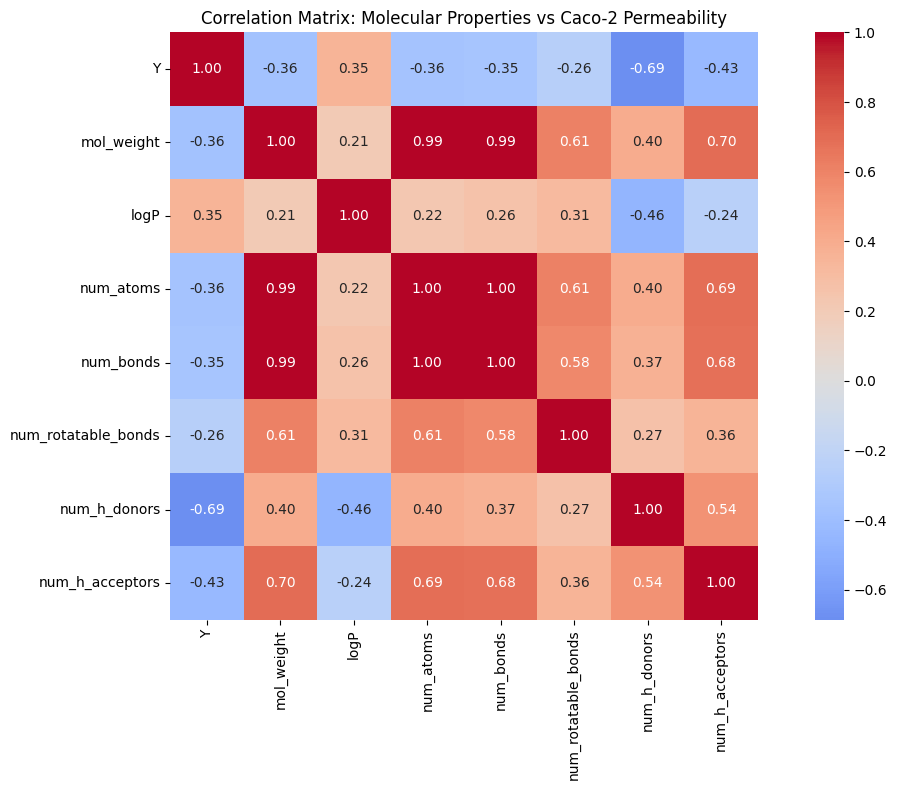

In [18]:
numeric_cols = ['Y', 'mol_weight', 'logP', 'num_atoms', 'num_bonds',
               'num_rotatable_bonds', 'num_h_donors', 'num_h_acceptors']

correlation_matrix = df[numeric_cols].corr()

# Plot correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, fmt='.2f')
plt.title('Correlation Matrix: Molecular Properties vs Caco-2 Permeability')
plt.tight_layout()
plt.show()

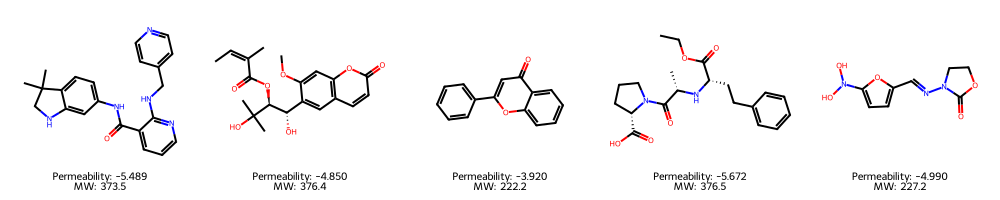


Molecule 1:
SMILES: CC1(C)CNc2cc(NC(=O)c3cccnc3NCc3ccncc3)ccc21
Caco-2 Permeability: -5.489
Molecular Weight: 373.5
LogP: 4.04

Molecule 2:
SMILES: C/C=C(/C)C(=O)O[C@@H]([C@@H](O)c1cc2ccc(=O)oc2cc1OC)C(C)(C)O
Caco-2 Permeability: -4.850
Molecular Weight: 376.4
LogP: 2.48

Molecule 3:
SMILES: O=c1cc(-c2ccccc2)oc2ccccc12
Caco-2 Permeability: -3.920
Molecular Weight: 222.2
LogP: 3.46

Molecule 4:
SMILES: CCOC(=O)[C@H](CCc1ccccc1)N[C@@H](C)C(=O)N1CCC[C@H]1C(=O)O
Caco-2 Permeability: -5.672
Molecular Weight: 376.5
LogP: 1.60

Molecule 5:
SMILES: O=C1OCCN1/N=C/c1ccc(N(O)O)o1
Caco-2 Permeability: -4.990
Molecular Weight: 227.2
LogP: 0.65


In [21]:
sample_df = df.sample(5, random_state=42)

mols = sample_df['mol'].tolist()
legends = [f"Permeability: {y:.3f}\nMW: {mw:.1f}"
           for y, mw in zip(sample_df['Y'], sample_df['mol_weight'])]

img = Draw.MolsToGridImage(mols, molsPerRow=min(5, 5), legends=legends, subImgSize=(200, 200))

display(img)

for i, (idx, row) in enumerate(sample_df.iterrows()):
    print(f"\nMolecule {i+1}:")
    print(f"SMILES: {row['Drug']}")
    print(f"Caco-2 Permeability: {row['Y']:.3f}")
    print(f"Molecular Weight: {row['mol_weight']:.1f}")
    print(f"LogP: {row['logP']:.2f}")